## 第7章：機械学習
本章では、Stanford Sentiment Treebank (SST) データセットを用い、評判分析器（ポジネガ分類器）を構築する。ここでは処理を簡略化するため、General Language Understanding Evaluation (GLUE) ベンチマークで配布されているSSTデータセットを用いる。

### 60.データの入手・整形
GLUEのウェブサイトからSST-2データセットを取得せよ。学習データ（train.tsv）と検証データ（dev.tsv）のぞれぞれについて、ポジティブ (1) とネガティブ (0) の事例数をカウントせよ。

In [1]:
! wget https://dl.fbaipublicfiles.com/glue/data/SST-2.zip

--2025-04-19 20:33:11--  https://dl.fbaipublicfiles.com/glue/data/SST-2.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.249.160.27, 13.249.160.55, 13.249.160.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.249.160.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7439277 (7.1M) [application/zip]
Saving to: ‘SST-2.zip’

SST-2.zip           100%[===================>]   7.09M  42.2MB/s    in 0.2s    

2025-04-19 20:33:11 (42.2 MB/s) - ‘SST-2.zip’ saved [7439277/7439277]



In [2]:
! unzip cp07-data/SST-2.zip

Archive:  cp07-data/SST-2.zip
   creating: SST-2/
  inflating: SST-2/dev.tsv           
   creating: SST-2/original/
  inflating: SST-2/original/README.txt  
  inflating: SST-2/original/SOStr.txt  
  inflating: SST-2/original/STree.txt  
  inflating: SST-2/original/datasetSentences.txt  
  inflating: SST-2/original/datasetSplit.txt  
  inflating: SST-2/original/dictionary.txt  
  inflating: SST-2/original/original_rt_snippets.txt  
  inflating: SST-2/original/sentiment_labels.txt  
  inflating: SST-2/test.tsv          
  inflating: SST-2/train.tsv         


In [8]:
import pandas as pd
import collections

def count(df):
    label = df['label']
    return collections.Counter(label)
df_train = pd.read_csv('cp07-data/SST-2/train.tsv', sep='\t')
df_dev = pd.read_csv('cp07-data/SST-2/dev.tsv', sep='\t')

print(f'train:{count(df_train)}')
print(f'dev:{count(df_dev)}')

train:Counter({1: 37569, 0: 29780})
dev:Counter({1: 444, 0: 428})


### 61.特徴ベクトル
Bag of Words (BoW) に基づき、学習データ（train.tsv）および検証データ（dev.tsv）のテキストを特徴ベクトルに変換したい。ここで、ある事例のテキストの特徴ベクトルは、テキスト中に含まれる単語（スペース区切りのトークン）の出現頻度で構成する。例えば、”too loud , too goofy”というテキストに対応する特徴ベクトルは、以下のような辞書オブジェクトで表現される。

{'too': 2, 'loud': 1, ',': 1, 'goofy': 1}

各事例はテキスト、特徴ベクトル、ラベルを格納した辞書オブジェクトでまとめておく。例えば、先ほどの”too loud , too goofy”に対してラベル”0”（ネガティブ）が付与された事例は、以下のオブジェクトで表現される。

{'text': 'too loud , too goofy', 'label': '0', 'feature': {'too': 2, 'loud': 1, ',': 1, 'goofy': 1}}

学習データと検証データの各事例を上記のような辞書オブジェクトに変換したうえで、学習データと検証データのそれぞれを、辞書オブジェクトのリストとして表現せよ。さらに、学習データの最初の事例について、正しく特徴ベクトルに変換できたか、目視で確認せよ。

In [52]:
import collections

def make_dic(path):
    df = pd.read_csv(path, sep='\t')
    dic = df.apply(count_word, axis=1)
    return dic


def count_word(data):
    words = data['sentence'].split(' ')
    feature = dict(collections.Counter(words))
    return {'text': data['sentence'], 'label': data['label'], 'feature': feature}

train_dic = make_dic('cp07-data/SST-2/train.tsv')
dev_dic = make_dic('cp07-data/SST-2/dev.tsv')

for i in range(10):
    print(train_dic[i])

{'text': 'hide new secretions from the parental units ', 'label': 0, 'feature': {'hide': 1, 'new': 1, 'secretions': 1, 'from': 1, 'the': 1, 'parental': 1, 'units': 1, '': 1}}
{'text': 'contains no wit , only labored gags ', 'label': 0, 'feature': {'contains': 1, 'no': 1, 'wit': 1, ',': 1, 'only': 1, 'labored': 1, 'gags': 1, '': 1}}
{'text': 'that loves its characters and communicates something rather beautiful about human nature ', 'label': 1, 'feature': {'that': 1, 'loves': 1, 'its': 1, 'characters': 1, 'and': 1, 'communicates': 1, 'something': 1, 'rather': 1, 'beautiful': 1, 'about': 1, 'human': 1, 'nature': 1, '': 1}}
{'text': 'remains utterly satisfied to remain the same throughout ', 'label': 0, 'feature': {'remains': 1, 'utterly': 1, 'satisfied': 1, 'to': 1, 'remain': 1, 'the': 1, 'same': 1, 'throughout': 1, '': 1}}
{'text': 'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ', 'label': 0, 'feature': {'on': 1, 'the': 2, 'worst': 1, 'revenge-of-the-nerds': 1

### 62.学習
61で構築した学習データの特徴ベクトルを用いて、ロジスティック回帰モデルを学習せよ。

In [69]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

X = [x['feature'] for x in train_dic]
Y = [y['label'] for y in train_dic]

# DictVectorizer でベクトル化
vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(X)


model = LogisticRegression()
model.fit(X, Y)

/net/nas8/data/home/yokoyama/nlp-100/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### 63.予測
学習したロジスティック回帰モデルを用い、検証データの先頭の事例のラベル（ポジネガ）を予測せよ。また、予測されたラベルが検証データに付与されていたラベルと一致しているか、確認せよ。

In [71]:
true_label = dev_dic[0]['label']
X = vectorizer.transform([dev_dic[0]['feature']])  # ← [] で包むのがポイント
Y_pred = model.predict(X)
print(f'true label: {true_label}')
print(f'out put: {Y_pred}')


true label: 1
out put: [1]


### 64.条件付き確率
学習したロジスティック回帰モデルを用い、検証データの先頭の事例を各ラベル（ネガポジ）に分類するときの条件付き確率を求めよ。

In [75]:
pro = model.predict_proba(X)

print(f'0: {pro[0][0]}')
print(f'1: {pro[0][1]}')

0: 0.004434954956884729
1: 0.9955650450431153


### 65.テキストのポジネガの予測
与えられたテキストのポジネガを予測するプログラムを実装せよ。例えば、テキストとして”the worst movie I ‘ve ever seen”を与え、ロジスティック回帰モデルの予測結果を確認せよ。

In [76]:
def make_feature(text):
    word = text.split()
    feature = dict(collections.Counter(word))
    return feature

text = "the worst movie I ‘ve ever seen"
feature = make_feature(text)
X = vectorizer.transform(feature)

Y_pred = model.predict(X)
print(f'out put: {Y_pred}')

out put: [0]


### 66.混合行列の作成
学習したロジスティック回帰モデルの検証用データにおける混合行列（confusion matrix）を求めよ。

                 predict_Positive  predict_Negative
actual_Positive               374                70
actual_Negative                96               332


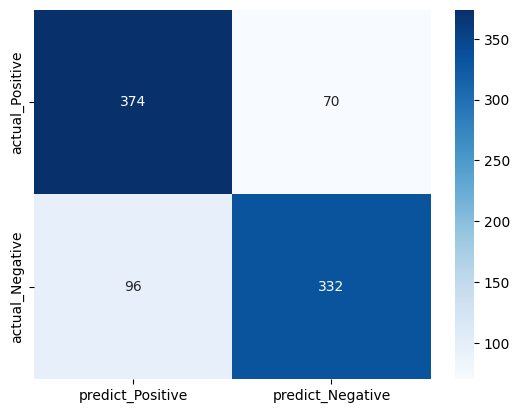

In [91]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


X = [x["feature"] for x in dev_dic]
Y_true = [y["label"] for y in dev_dic]

X = np.squeeze(vectorizer.transform(X))
Y_pred = model.predict(X)

cm = confusion_matrix(y_true=Y_true, y_pred=Y_pred)

# y_trueに渡すのは、評価用の目的変数データ
# y_predに渡すのは、X_testでpredict()関数を使って予測した結果

# 混同行列をデータフレーム化
df_cm = pd.DataFrame(np.rot90(cm, 2), index=["actual_Positive", "actual_Negative"], columns=["predict_Positive", "predict_Negative"])
print(df_cm)

# heatmapによる混同行列の可視化
sns.heatmap(df_cm, annot=True, fmt="2g", cmap='Blues')
plt.yticks(va='center')
plt.show()


### 67.精度の計測
学習したロジスティック回帰モデルの正解率、適合率、再現率、F1スコアを、学習データおよび検証データ上で計測せよ。

In [92]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def do_measure(dic, name):
    X = [x["feature"] for x in dic]
    Y_true = [y["label"] for y in dic]

    X = np.squeeze(vectorizer.transform(X))
    Y_pred = model.predict(X)
    print(name)
    print(f"Accuracy : {accuracy_score(Y_true, Y_pred)}")
    print(f"Precision: {precision_score(Y_true, Y_pred)}")
    print(f"Recall   : {recall_score(Y_true, Y_pred)}")
    print(f"F1 Score : {f1_score(Y_true, Y_pred)}")


do_measure(train_dic, 'train')
do_measure(dev_dic, 'dev')

train
Accuracy : 0.9401178933614456
Precision: 0.9402436462927957
Recall   : 0.9532327184646916
F1 Score : 0.9466936304638037
dev
Accuracy : 0.8096330275229358
Precision: 0.7957446808510639
Recall   : 0.8423423423423423
F1 Score : 0.8183807439824945


### 68.特徴量の重みの確認
学習したロジスティック回帰モデルの中で、重みの高い特徴量トップ20と、重みの低い特徴量トップ20を確認せよ。

In [97]:
import numpy as np

# 特徴量の名前（vectorizerを使っている前提）
feature_names = vectorizer.get_feature_names_out()

# 学習済みロジスティック回帰モデルの係数を取得（1次元にする）
weights = model.coef_[0]

# 重みの大きい順、低い順のインデックス
top20_idx = np.argsort(weights)[-20:][::-1]  # 高い順
bottom20_idx = np.argsort(weights)[:20]      # 低い順

print("重みの高い特徴量 Top 20:")
for i in top20_idx:
    print(f"{feature_names[i]:<20} {weights[i]:.4f}")

print("\n重みの低い特徴量 Top 20:")
for i in bottom20_idx:
    print(f"{feature_names[i]:<20} {weights[i]:.4f}")

重みの高い特徴量 Top 20:
refreshing           3.5648
remarkable           3.4821
powerful             3.2853
hilarious            3.1282
treat                3.0991
terrific             2.9899
wonderful            2.9777
beautiful            2.9464
charmer              2.8888
enjoyable            2.8770
appealing            2.8198
vividly              2.7796
likable              2.7421
miracle              2.6707
impressive           2.5866
wonderfully          2.5599
fascinating          2.5582
prose                2.5566
brilliant            2.5346
engrossing           2.5276

重みの低い特徴量 Top 20:
lacking              -4.3294
lacks                -4.1355
worst                -3.8895
devoid               -3.7459
mess                 -3.6958
failure              -3.6500
bore                 -3.3718
stupid               -3.3100
loses                -3.2297
waste                -3.1920
lousy                -3.1734
pointless            -3.1146
lack                 -3.1120
flat                 -3.1101

### 69.正規化パラメータの変更
ロジスティック回帰モデルを学習するとき、正則化の係数（ハイパーパラメータ）を調整することで、学習時の適合度合いを制御できる。正則化の係数を変化させながらロジスティック回帰モデルを学習し、検証データ上の正解率を求めよ。実験の結果は、正則化パラメータを横軸、正解率を縦軸としたグラフにまとめよ。

C=0.0001 → Accuracy=0.5206
C=0.0008 → Accuracy=0.6732
C=0.0060 → Accuracy=0.7339
C=0.0464 → Accuracy=0.8028
C=0.3594 → Accuracy=0.8073
C=2.7826 → Accuracy=0.8177
C=21.5443 → Accuracy=0.8165
C=166.8101 → Accuracy=0.7890
C=1291.5497 → Accuracy=0.7878
C=10000.0000 → Accuracy=0.7913


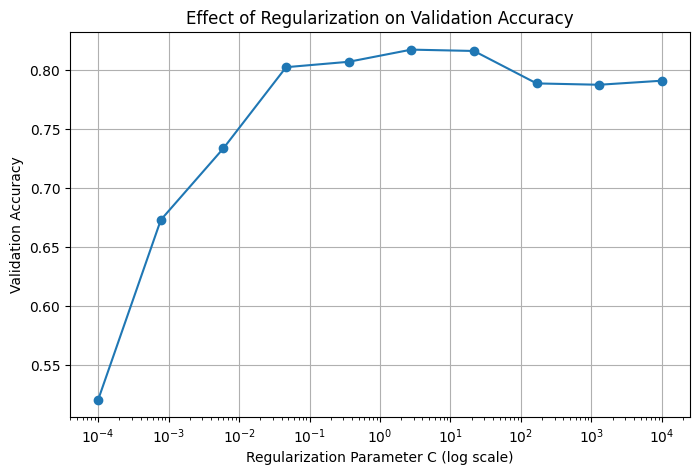

In [98]:
# データ準備
X_train = [x['feature'] for x in train_dic]
y_train = [x['label'] for x in train_dic]
X_dev = [x['feature'] for x in dev_dic]
y_dev = [x['label'] for x in dev_dic]

# 特徴ベクトル化
vectorizer = DictVectorizer(sparse=False)
X_train_vec = vectorizer.fit_transform(X_train)
X_dev_vec = vectorizer.transform(X_dev)

# Cの値を変えて精度を検証
C_values = np.logspace(-4, 4, 10)  # 0.0001 〜 10000 の対数刻み
accuracy_list = []

for C in C_values:
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_dev_vec)
    acc = accuracy_score(y_dev, y_pred)
    accuracy_list.append(acc)
    print(f"C={C:.4f} → Accuracy={acc:.4f}")

# グラフ描画
plt.figure(figsize=(8, 5))
plt.plot(C_values, accuracy_list, marker='o')
plt.xscale('log')
plt.xlabel("Regularization Parameter C (log scale)")
plt.ylabel("Validation Accuracy")
plt.title("Effect of Regularization on Validation Accuracy")
plt.grid(True)
plt.show()